In [1]:
import pandas as pd
import numpy as np
import string,re,nltk

In [4]:
from nltk import WordNetLemmatizer
stopwords=nltk.corpus.stopwords.words('english')
wn=WordNetLemmatizer()

In [5]:
data=pd.read_csv('C:/Users/Akshat/Downloads/amazon-fine-food-reviews/Reviews.csv')

In [6]:
data.shape

(568454, 10)

In [30]:
import warnings 
warnings.filterwarnings('ignore')

In [7]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
df1 = data.iloc[:, [4,5,6,9]]
df1.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text
0,1,1,5,I have bought several of the Vitality canned d...
1,0,0,1,Product arrived labeled as Jumbo Salted Peanut...
2,1,1,4,This is a confection that has been around a fe...
3,3,3,2,If you are looking for the secret ingredient i...
4,0,0,5,Great taffy at a great price. There was a wid...


Variable: Description | Type of Variable

HelpfulnessNumerator: number of users who found the review helpful | continuous

HelpfulnessDenominator: number of users who indicated whether they found the review helpful or not helpful | continuous

Score: rating between 1 and 5 | categorical

Text: text of the review | text

In [19]:
#include reviews that have more than 5 helpfulness data point only
df1 = df1[(df1.HelpfulnessDenominator > 5)]

In [20]:
df1.shape

(52643, 5)

In [21]:
df1['helpful']=np.where((df1.loc[:,'HelpfulnessNumerator']/df1.loc[:,'HelpfulnessDenominator'])>0.5,1,0)

In [22]:
df1.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,helpful
32,19,19,4,McCann's Instant Oatmeal is great if you must ...,1
33,13,13,4,This is a good instant oatmeal from the best o...,1
34,9,9,5,Instant oatmeal can become soggy the minute th...,1
50,0,7,1,"This oatmeal is not good. Its mushy, soft, I d...",0
82,15,15,5,I know the product title says Molecular Gastro...,1


In [16]:
df1.shape

(568454, 5)

In [26]:
X=df1[['Text']]
Y=df1['helpful']

In [14]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace('\s+', ' ')
    df[text_field] = df[text_field].str.replace("\'", "")
    return df

In [31]:
X=standardize_text(X,'Text')

In [32]:
def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=3)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text,ngram_range=(1,2))
tfidf_vect_fit = tfidf_vect.fit(X_train['Text'])
tfidf_train = tfidf_vect_fit.transform(X_train['Text'])
tfidf_test = tfidf_vect_fit.transform(X_test['Text'])

In [71]:
vocab = tfidf_vect.get_feature_names()

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve

In [42]:
param=[0.01,0.001,1,10,50,30,100,0.1]
accu=[]
for i in param:
    lr=LogisticRegression(C=i,class_weight='balanced', solver='newton-cg', random_state=40,
                               multi_class='multinomial')
    model=lr.fit(tfidf_train,y_train)
    predd=model.predict(tfidf_test)
    accu.append(accuracy_score(predd,y_test))

In [43]:
x=pd.DataFrame(accu,index=param)
x

,0
0.010,0.732263
0.001,0.700161
1.000,0.812043
10.000,0.835787
50.000,0.834837
30.000,0.834742
100.000,0.835502
0.100,0.769589


In [45]:
lr=LogisticRegression(C=30,class_weight='balanced', solver='newton-cg', random_state=40,
                           multi_class='multinomial')
model=lr.fit(tfidf_train,y_train)
predd=model.predict(tfidf_test)
#accu.append(accuracy_score(predd,y_test))

In [46]:
print(classification_report(predd,y_test))

             precision    recall  f1-score   support

          0       0.71      0.59      0.65      2666
          1       0.87      0.92      0.89      7863

avg / total       0.83      0.83      0.83     10529



In [50]:
print(confusion_matrix(predd,y_test,labels=[0,1]))

[[1581 1085]
 [ 655 7208]]


In [56]:
def AUC(model,predd):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(tfidf_test)[:,1])
    f_rf_roc_auc=roc_auc_score(y_test,predd)
    plt.figure()
    plt.plot(fpr, tpr, label='Classification (area = %0.2f)' % f_rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

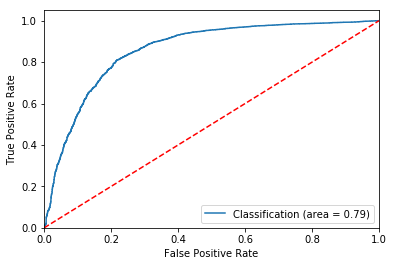

In [62]:
AUC(model,predd)

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text,ngram_range=(1,2))
tfidf_vect_fit = tfidf_vect.fit(X_train['Text'])
tfidf_train = tfidf_vect_fit.transform(X_train['Text'])
tfidf_test = tfidf_vect_fit.transform(X_test['Text'])

In [90]:
lr=LogisticRegression(C=30,class_weight='balanced', solver='newton-cg', random_state=40)
model=lr.fit(tfidf_train,y_train)
predd=model.predict(tfidf_test)
#accu.append(accuracy_score(predd,y_test))
print(classification_report(predd,y_test))
print(confusion_matrix(predd,y_test,labels=[0,1]))

             precision    recall  f1-score   support

          0       0.72      0.60      0.65      2701
          1       0.87      0.92      0.89      7828

avg / total       0.83      0.84      0.83     10529

[[1614 1087]
 [ 622 7206]]


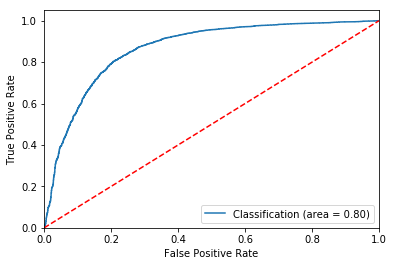

In [70]:
AUC(model,predd)

In [84]:
accuracy_score(predd,y_test)

0.83768638997055755

In [91]:
sentences = [
    "I tried this soup and this is the last time i ate this thing.",
    "THIS SUX!!!",
    "it's healthy ",
    "perfect item for me and my family",
    '$100 for this..man they are looting us like anything','good item to start your day with','i am going to SUE their asses!',
    'pathetic and disgusting!!','my taste buds are loving it','this shit is amazing man!!'
            ]
#hash_vect_sample = TfidfVectorizer(analyzer=clean_text)
test = tfidf_vect_fit.transform(sentences)

In [92]:
lr_pre=model.predict(test)

In [93]:
lr_pre=pd.DataFrame(lr_pre)
lr_pre.loc[lr_pre[0]==0, 0] = 'not helpful'
lr_pre.loc[lr_pre[0]==1, 0] = 'helpful'

In [81]:
for review, category in zip(sentences, lr_pre[0]):
    print('%r => %s' % (review, category))

'I tried this soup and this is the last time i ate this thing.' => not helpful
'THIS SUX!!!' => not helpful
"it's healthy " => not helpful
'perfect item for me and my family' => helpful
'$100 for this..man they are looting us like anything' => not helpful
'good item to start your day with' => helpful
'i am going to SUE their asses!' => not helpful
'pathetic and disgusting!!' => not helpful
'my taste buds are loving it' => not helpful
'this shit is amazing man!!' => not helpful


In [94]:
for review, category in zip(sentences, lr_pre[0]):
    print('%r => %s' % (review, category))

'I tried this soup and this is the last time i ate this thing.' => not helpful
'THIS SUX!!!' => not helpful
"it's healthy " => not helpful
'perfect item for me and my family' => helpful
'$100 for this..man they are looting us like anything' => not helpful
'good item to start your day with' => helpful
'i am going to SUE their asses!' => not helpful
'pathetic and disgusting!!' => not helpful
'my taste buds are loving it' => not helpful
'this shit is amazing man!!' => not helpful


In [95]:
train_set=tfidf_train[:,[np.argwhere(vocab==i)[0][0] for i in words]]

IndexError: index 0 is out of bounds for axis 0 with size 0